In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import cycle
import pandas as pd

c:\Users\Gu\anaconda3\envs\pytorch2.2.2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Gu\anaconda3\envs\pytorch2.2.2\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 1. Data Processing and Augmentation

In [2]:
class SVHNDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None, download=True):
        self.data = datasets.SVHN(root=root, split=split, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            transformed = self.transform(image=np.array(image))
            image = transformed['image']
        return image, label

# 定义训练数据增强和预处理流水线
train_transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
    ToTensorV2()
])

# 定义测试数据增强和预处理流水线
test_transform = A.Compose([
    A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
    ToTensorV2()
])

# 加载训练集和测试集
train_dataset = SVHNDataset(root="data/", split='train', transform=train_transform, download=True)
test_dataset = SVHNDataset(root="data/", split='test', transform=test_transform, download=True)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 打印一些信息以确认数据集加载成功
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

  1%|▏         | 2.69M/182M [00:10<11:30, 260kB/s] 


KeyboardInterrupt: 

# 2. Neural Network Setup

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.BatchNorm2d(8), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16

            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8

            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8 -> 4
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 4 * 4, 256), nn.ReLU(),
            nn.Dropout(p=0.2),  # 添加 Dropout 层，丢弃率为 20%
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# 3. Training and Evaluation Functions

In [10]:
# 训练和评估函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(images)

    return running_loss / len(train_loader.dataset)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * len(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    accuracy = correct / total
    test_loss = test_loss / len(test_loader.dataset)

    # Calculate ROC AUC
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    all_labels_one_hot = np.eye(10)[all_labels]

    # Macro ROC AUC
    macro_roc_auc = roc_auc_score(all_labels_one_hot, all_outputs, average='macro', multi_class='ovr')

    # Micro ROC AUC
    micro_roc_auc = roc_auc_score(all_labels_one_hot, all_outputs, average='micro', multi_class='ovr')

    return test_loss, accuracy, macro_roc_auc, micro_roc_auc, all_labels, all_outputs


# 4. Analysis of Training and Evaluation 

Running experiment with {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 1145/1145 [00:29<00:00, 38.65it/s]


Epoch 1/20, Train Loss: 0.7346, Test Loss: 0.3777, Accuracy: 0.8853, Macro ROC AUC: 0.9764, Micro ROC AUC: 0.9765


100%|██████████| 1145/1145 [00:22<00:00, 50.89it/s]


Epoch 2/20, Train Loss: 0.4181, Test Loss: 0.3030, Accuracy: 0.9111, Macro ROC AUC: 0.9825, Micro ROC AUC: 0.9834


100%|██████████| 1145/1145 [00:22<00:00, 51.93it/s]


Epoch 3/20, Train Loss: 0.3666, Test Loss: 0.2637, Accuracy: 0.9252, Macro ROC AUC: 0.9855, Micro ROC AUC: 0.9862


100%|██████████| 1145/1145 [00:58<00:00, 19.67it/s]


Epoch 4/20, Train Loss: 0.3339, Test Loss: 0.2661, Accuracy: 0.9242, Macro ROC AUC: 0.9866, Micro ROC AUC: 0.9868


100%|██████████| 1145/1145 [01:24<00:00, 13.63it/s]


Epoch 5/20, Train Loss: 0.3163, Test Loss: 0.2399, Accuracy: 0.9318, Macro ROC AUC: 0.9885, Micro ROC AUC: 0.9890


100%|██████████| 1145/1145 [00:42<00:00, 26.74it/s]


Epoch 6/20, Train Loss: 0.3007, Test Loss: 0.2340, Accuracy: 0.9336, Macro ROC AUC: 0.9898, Micro ROC AUC: 0.9892


100%|██████████| 1145/1145 [00:56<00:00, 20.29it/s]


Epoch 7/20, Train Loss: 0.2869, Test Loss: 0.2305, Accuracy: 0.9339, Macro ROC AUC: 0.9898, Micro ROC AUC: 0.9900


100%|██████████| 1145/1145 [00:20<00:00, 54.72it/s]


Epoch 8/20, Train Loss: 0.2768, Test Loss: 0.2332, Accuracy: 0.9339, Macro ROC AUC: 0.9901, Micro ROC AUC: 0.9901


100%|██████████| 1145/1145 [00:20<00:00, 56.04it/s]


Epoch 9/20, Train Loss: 0.2681, Test Loss: 0.2312, Accuracy: 0.9363, Macro ROC AUC: 0.9904, Micro ROC AUC: 0.9903


100%|██████████| 1145/1145 [00:20<00:00, 55.93it/s]


Epoch 10/20, Train Loss: 0.2611, Test Loss: 0.2147, Accuracy: 0.9427, Macro ROC AUC: 0.9919, Micro ROC AUC: 0.9919


100%|██████████| 1145/1145 [00:20<00:00, 55.47it/s]


Epoch 11/20, Train Loss: 0.2524, Test Loss: 0.2218, Accuracy: 0.9390, Macro ROC AUC: 0.9914, Micro ROC AUC: 0.9914


100%|██████████| 1145/1145 [00:20<00:00, 55.61it/s]


Epoch 12/20, Train Loss: 0.2484, Test Loss: 0.2124, Accuracy: 0.9420, Macro ROC AUC: 0.9916, Micro ROC AUC: 0.9918


100%|██████████| 1145/1145 [00:20<00:00, 55.49it/s]


Epoch 13/20, Train Loss: 0.2425, Test Loss: 0.1974, Accuracy: 0.9475, Macro ROC AUC: 0.9928, Micro ROC AUC: 0.9932


100%|██████████| 1145/1145 [00:24<00:00, 46.79it/s]


Epoch 14/20, Train Loss: 0.2355, Test Loss: 0.2138, Accuracy: 0.9421, Macro ROC AUC: 0.9922, Micro ROC AUC: 0.9923


100%|██████████| 1145/1145 [00:51<00:00, 22.24it/s]


Epoch 15/20, Train Loss: 0.2278, Test Loss: 0.2042, Accuracy: 0.9449, Macro ROC AUC: 0.9925, Micro ROC AUC: 0.9926


100%|██████████| 1145/1145 [00:23<00:00, 49.10it/s]


Epoch 16/20, Train Loss: 0.2262, Test Loss: 0.2008, Accuracy: 0.9455, Macro ROC AUC: 0.9929, Micro ROC AUC: 0.9930


100%|██████████| 1145/1145 [00:22<00:00, 51.10it/s]


Epoch 17/20, Train Loss: 0.2223, Test Loss: 0.2012, Accuracy: 0.9461, Macro ROC AUC: 0.9930, Micro ROC AUC: 0.9930


100%|██████████| 1145/1145 [00:22<00:00, 50.07it/s]


Epoch 18/20, Train Loss: 0.2214, Test Loss: 0.2009, Accuracy: 0.9460, Macro ROC AUC: 0.9929, Micro ROC AUC: 0.9932


100%|██████████| 1145/1145 [00:22<00:00, 50.05it/s]


Epoch 19/20, Train Loss: 0.2160, Test Loss: 0.2122, Accuracy: 0.9424, Macro ROC AUC: 0.9924, Micro ROC AUC: 0.9926


100%|██████████| 1145/1145 [00:23<00:00, 48.00it/s]


Epoch 20/20, Train Loss: 0.2141, Test Loss: 0.2000, Accuracy: 0.9472, Macro ROC AUC: 0.9933, Micro ROC AUC: 0.9933
Running experiment with {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 1145/1145 [00:24<00:00, 46.12it/s]


Epoch 1/20, Train Loss: 1.4475, Test Loss: 0.6789, Accuracy: 0.7942, Macro ROC AUC: 0.9423, Micro ROC AUC: 0.9492


100%|██████████| 1145/1145 [00:24<00:00, 46.68it/s]


Epoch 2/20, Train Loss: 0.7186, Test Loss: 0.4922, Accuracy: 0.8523, Macro ROC AUC: 0.9613, Micro ROC AUC: 0.9659


100%|██████████| 1145/1145 [00:22<00:00, 50.10it/s]


Epoch 3/20, Train Loss: 0.5647, Test Loss: 0.4130, Accuracy: 0.8753, Macro ROC AUC: 0.9702, Micro ROC AUC: 0.9729


100%|██████████| 1145/1145 [00:22<00:00, 50.08it/s]


Epoch 4/20, Train Loss: 0.4929, Test Loss: 0.3615, Accuracy: 0.8928, Macro ROC AUC: 0.9754, Micro ROC AUC: 0.9776


100%|██████████| 1145/1145 [00:24<00:00, 45.85it/s]


Epoch 5/20, Train Loss: 0.4449, Test Loss: 0.3399, Accuracy: 0.8993, Macro ROC AUC: 0.9782, Micro ROC AUC: 0.9793


100%|██████████| 1145/1145 [00:24<00:00, 45.92it/s]


Epoch 6/20, Train Loss: 0.4135, Test Loss: 0.3183, Accuracy: 0.9065, Macro ROC AUC: 0.9799, Micro ROC AUC: 0.9807


100%|██████████| 1145/1145 [00:24<00:00, 47.46it/s]


Epoch 7/20, Train Loss: 0.3873, Test Loss: 0.3039, Accuracy: 0.9105, Macro ROC AUC: 0.9815, Micro ROC AUC: 0.9823


100%|██████████| 1145/1145 [00:22<00:00, 50.17it/s]


Epoch 8/20, Train Loss: 0.3669, Test Loss: 0.2890, Accuracy: 0.9156, Macro ROC AUC: 0.9832, Micro ROC AUC: 0.9834


100%|██████████| 1145/1145 [00:22<00:00, 50.41it/s]


Epoch 9/20, Train Loss: 0.3495, Test Loss: 0.2776, Accuracy: 0.9185, Macro ROC AUC: 0.9840, Micro ROC AUC: 0.9848


100%|██████████| 1145/1145 [00:22<00:00, 49.81it/s]


Epoch 10/20, Train Loss: 0.3363, Test Loss: 0.2727, Accuracy: 0.9209, Macro ROC AUC: 0.9849, Micro ROC AUC: 0.9857


100%|██████████| 1145/1145 [00:22<00:00, 50.71it/s]


Epoch 11/20, Train Loss: 0.3213, Test Loss: 0.2672, Accuracy: 0.9240, Macro ROC AUC: 0.9857, Micro ROC AUC: 0.9859


100%|██████████| 1145/1145 [00:22<00:00, 50.07it/s]


Epoch 12/20, Train Loss: 0.3150, Test Loss: 0.2633, Accuracy: 0.9244, Macro ROC AUC: 0.9858, Micro ROC AUC: 0.9862


100%|██████████| 1145/1145 [00:24<00:00, 46.22it/s]


Epoch 13/20, Train Loss: 0.3054, Test Loss: 0.2538, Accuracy: 0.9273, Macro ROC AUC: 0.9863, Micro ROC AUC: 0.9874


100%|██████████| 1145/1145 [00:23<00:00, 49.45it/s]


Epoch 14/20, Train Loss: 0.2962, Test Loss: 0.2486, Accuracy: 0.9279, Macro ROC AUC: 0.9871, Micro ROC AUC: 0.9873


100%|██████████| 1145/1145 [00:22<00:00, 49.91it/s]


Epoch 15/20, Train Loss: 0.2905, Test Loss: 0.2388, Accuracy: 0.9322, Macro ROC AUC: 0.9877, Micro ROC AUC: 0.9883


100%|██████████| 1145/1145 [00:22<00:00, 49.86it/s]


Epoch 16/20, Train Loss: 0.2827, Test Loss: 0.2398, Accuracy: 0.9334, Macro ROC AUC: 0.9881, Micro ROC AUC: 0.9884


100%|██████████| 1145/1145 [00:23<00:00, 48.29it/s]


Epoch 17/20, Train Loss: 0.2744, Test Loss: 0.2449, Accuracy: 0.9308, Macro ROC AUC: 0.9881, Micro ROC AUC: 0.9884


100%|██████████| 1145/1145 [00:25<00:00, 45.54it/s]


Epoch 18/20, Train Loss: 0.2721, Test Loss: 0.2329, Accuracy: 0.9347, Macro ROC AUC: 0.9886, Micro ROC AUC: 0.9890


100%|██████████| 1145/1145 [00:23<00:00, 47.79it/s]


Epoch 19/20, Train Loss: 0.2670, Test Loss: 0.2256, Accuracy: 0.9372, Macro ROC AUC: 0.9889, Micro ROC AUC: 0.9895


100%|██████████| 1145/1145 [00:23<00:00, 49.20it/s]


Epoch 20/20, Train Loss: 0.2621, Test Loss: 0.2251, Accuracy: 0.9369, Macro ROC AUC: 0.9890, Micro ROC AUC: 0.9896
Running experiment with {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 2290/2290 [00:30<00:00, 75.54it/s]


Epoch 1/20, Train Loss: 0.7078, Test Loss: 0.3503, Accuracy: 0.8995, Macro ROC AUC: 0.9779, Micro ROC AUC: 0.9794


100%|██████████| 2290/2290 [00:30<00:00, 74.13it/s]


Epoch 2/20, Train Loss: 0.4217, Test Loss: 0.2881, Accuracy: 0.9182, Macro ROC AUC: 0.9848, Micro ROC AUC: 0.9852


100%|██████████| 2290/2290 [00:29<00:00, 78.36it/s]


Epoch 3/20, Train Loss: 0.3696, Test Loss: 0.2577, Accuracy: 0.9262, Macro ROC AUC: 0.9883, Micro ROC AUC: 0.9885


100%|██████████| 2290/2290 [00:28<00:00, 79.47it/s]


Epoch 4/20, Train Loss: 0.3388, Test Loss: 0.2504, Accuracy: 0.9285, Macro ROC AUC: 0.9895, Micro ROC AUC: 0.9895


100%|██████████| 2290/2290 [00:29<00:00, 77.89it/s]


Epoch 5/20, Train Loss: 0.3209, Test Loss: 0.2371, Accuracy: 0.9333, Macro ROC AUC: 0.9898, Micro ROC AUC: 0.9900


100%|██████████| 2290/2290 [00:29<00:00, 76.95it/s]


Epoch 6/20, Train Loss: 0.3045, Test Loss: 0.2352, Accuracy: 0.9353, Macro ROC AUC: 0.9912, Micro ROC AUC: 0.9912


100%|██████████| 2290/2290 [00:30<00:00, 75.45it/s]


Epoch 7/20, Train Loss: 0.2921, Test Loss: 0.2181, Accuracy: 0.9388, Macro ROC AUC: 0.9920, Micro ROC AUC: 0.9921


100%|██████████| 2290/2290 [00:29<00:00, 77.58it/s]


Epoch 8/20, Train Loss: 0.2822, Test Loss: 0.2227, Accuracy: 0.9374, Macro ROC AUC: 0.9924, Micro ROC AUC: 0.9923


100%|██████████| 2290/2290 [00:29<00:00, 78.65it/s]


Epoch 9/20, Train Loss: 0.2730, Test Loss: 0.2124, Accuracy: 0.9431, Macro ROC AUC: 0.9928, Micro ROC AUC: 0.9930


100%|██████████| 2290/2290 [00:28<00:00, 80.02it/s]


Epoch 10/20, Train Loss: 0.2657, Test Loss: 0.2147, Accuracy: 0.9400, Macro ROC AUC: 0.9929, Micro ROC AUC: 0.9932


100%|██████████| 2290/2290 [00:28<00:00, 80.35it/s]


Epoch 11/20, Train Loss: 0.2592, Test Loss: 0.2145, Accuracy: 0.9414, Macro ROC AUC: 0.9934, Micro ROC AUC: 0.9933


100%|██████████| 2290/2290 [00:28<00:00, 79.94it/s]


Epoch 12/20, Train Loss: 0.2534, Test Loss: 0.2070, Accuracy: 0.9429, Macro ROC AUC: 0.9934, Micro ROC AUC: 0.9935


100%|██████████| 2290/2290 [00:29<00:00, 78.48it/s]


Epoch 13/20, Train Loss: 0.2462, Test Loss: 0.2075, Accuracy: 0.9433, Macro ROC AUC: 0.9936, Micro ROC AUC: 0.9938


100%|██████████| 2290/2290 [00:28<00:00, 79.11it/s]


Epoch 14/20, Train Loss: 0.2395, Test Loss: 0.2125, Accuracy: 0.9418, Macro ROC AUC: 0.9935, Micro ROC AUC: 0.9936


100%|██████████| 2290/2290 [00:28<00:00, 80.76it/s]


Epoch 15/20, Train Loss: 0.2370, Test Loss: 0.2108, Accuracy: 0.9415, Macro ROC AUC: 0.9941, Micro ROC AUC: 0.9940


100%|██████████| 2290/2290 [00:28<00:00, 81.38it/s]


Epoch 16/20, Train Loss: 0.2330, Test Loss: 0.1999, Accuracy: 0.9453, Macro ROC AUC: 0.9943, Micro ROC AUC: 0.9943


100%|██████████| 2290/2290 [00:28<00:00, 79.12it/s]


Epoch 17/20, Train Loss: 0.2284, Test Loss: 0.2155, Accuracy: 0.9408, Macro ROC AUC: 0.9939, Micro ROC AUC: 0.9939


100%|██████████| 2290/2290 [00:29<00:00, 78.82it/s]


Epoch 18/20, Train Loss: 0.2244, Test Loss: 0.2098, Accuracy: 0.9441, Macro ROC AUC: 0.9940, Micro ROC AUC: 0.9942


100%|██████████| 2290/2290 [00:28<00:00, 79.35it/s]


Epoch 19/20, Train Loss: 0.2209, Test Loss: 0.2121, Accuracy: 0.9426, Macro ROC AUC: 0.9941, Micro ROC AUC: 0.9942


100%|██████████| 2290/2290 [00:29<00:00, 77.66it/s]


Epoch 20/20, Train Loss: 0.2173, Test Loss: 0.2063, Accuracy: 0.9451, Macro ROC AUC: 0.9945, Micro ROC AUC: 0.9946
Running experiment with {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 1145/1145 [00:22<00:00, 49.82it/s]


Epoch 1/10, Train Loss: 0.7659, Test Loss: 0.3756, Accuracy: 0.8876, Macro ROC AUC: 0.9768, Micro ROC AUC: 0.9774


100%|██████████| 1145/1145 [00:22<00:00, 49.99it/s]


Epoch 2/10, Train Loss: 0.4231, Test Loss: 0.3205, Accuracy: 0.9048, Macro ROC AUC: 0.9822, Micro ROC AUC: 0.9828


100%|██████████| 1145/1145 [00:22<00:00, 49.88it/s]


Epoch 3/10, Train Loss: 0.3645, Test Loss: 0.2579, Accuracy: 0.9244, Macro ROC AUC: 0.9868, Micro ROC AUC: 0.9873


100%|██████████| 1145/1145 [00:23<00:00, 49.51it/s]


Epoch 4/10, Train Loss: 0.3315, Test Loss: 0.2566, Accuracy: 0.9266, Macro ROC AUC: 0.9881, Micro ROC AUC: 0.9873


100%|██████████| 1145/1145 [00:23<00:00, 48.19it/s]


Epoch 5/10, Train Loss: 0.3076, Test Loss: 0.2452, Accuracy: 0.9290, Macro ROC AUC: 0.9889, Micro ROC AUC: 0.9890


100%|██████████| 1145/1145 [00:23<00:00, 47.72it/s]


Epoch 6/10, Train Loss: 0.2967, Test Loss: 0.2270, Accuracy: 0.9355, Macro ROC AUC: 0.9903, Micro ROC AUC: 0.9905


100%|██████████| 1145/1145 [00:24<00:00, 47.25it/s]


Epoch 7/10, Train Loss: 0.2839, Test Loss: 0.2193, Accuracy: 0.9373, Macro ROC AUC: 0.9903, Micro ROC AUC: 0.9906


100%|██████████| 1145/1145 [00:22<00:00, 49.89it/s]


Epoch 8/10, Train Loss: 0.2743, Test Loss: 0.2268, Accuracy: 0.9360, Macro ROC AUC: 0.9907, Micro ROC AUC: 0.9904


100%|██████████| 1145/1145 [00:22<00:00, 50.54it/s]


Epoch 9/10, Train Loss: 0.2629, Test Loss: 0.2168, Accuracy: 0.9393, Macro ROC AUC: 0.9910, Micro ROC AUC: 0.9911


100%|██████████| 1145/1145 [00:22<00:00, 50.66it/s]


Epoch 10/10, Train Loss: 0.2585, Test Loss: 0.2192, Accuracy: 0.9380, Macro ROC AUC: 0.9918, Micro ROC AUC: 0.9916
Running experiment with {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'sgd', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 1145/1145 [00:22<00:00, 50.39it/s]


Epoch 1/20, Train Loss: 1.4366, Test Loss: 0.6129, Accuracy: 0.8118, Macro ROC AUC: 0.9463, Micro ROC AUC: 0.9515


100%|██████████| 1145/1145 [00:22<00:00, 50.67it/s]


Epoch 2/20, Train Loss: 0.6435, Test Loss: 0.4503, Accuracy: 0.8661, Macro ROC AUC: 0.9617, Micro ROC AUC: 0.9633


100%|██████████| 1145/1145 [00:22<00:00, 50.16it/s]


Epoch 3/20, Train Loss: 0.4988, Test Loss: 0.3510, Accuracy: 0.8954, Macro ROC AUC: 0.9725, Micro ROC AUC: 0.9748


100%|██████████| 1145/1145 [00:22<00:00, 49.87it/s]


Epoch 4/20, Train Loss: 0.4347, Test Loss: 0.3113, Accuracy: 0.9096, Macro ROC AUC: 0.9769, Micro ROC AUC: 0.9780


100%|██████████| 1145/1145 [00:24<00:00, 47.08it/s]


Epoch 5/20, Train Loss: 0.3974, Test Loss: 0.3002, Accuracy: 0.9107, Macro ROC AUC: 0.9782, Micro ROC AUC: 0.9800


100%|██████████| 1145/1145 [00:23<00:00, 48.06it/s]


Epoch 6/20, Train Loss: 0.3680, Test Loss: 0.2775, Accuracy: 0.9210, Macro ROC AUC: 0.9805, Micro ROC AUC: 0.9813


100%|██████████| 1145/1145 [00:23<00:00, 49.68it/s]


Epoch 7/20, Train Loss: 0.3470, Test Loss: 0.2689, Accuracy: 0.9236, Macro ROC AUC: 0.9812, Micro ROC AUC: 0.9820


100%|██████████| 1145/1145 [00:22<00:00, 50.73it/s]


Epoch 8/20, Train Loss: 0.3320, Test Loss: 0.2733, Accuracy: 0.9199, Macro ROC AUC: 0.9816, Micro ROC AUC: 0.9828


100%|██████████| 1145/1145 [00:22<00:00, 50.65it/s]


Epoch 9/20, Train Loss: 0.3173, Test Loss: 0.2593, Accuracy: 0.9250, Macro ROC AUC: 0.9828, Micro ROC AUC: 0.9840


100%|██████████| 1145/1145 [00:22<00:00, 50.73it/s]


Epoch 10/20, Train Loss: 0.3069, Test Loss: 0.2598, Accuracy: 0.9235, Macro ROC AUC: 0.9829, Micro ROC AUC: 0.9836


100%|██████████| 1145/1145 [00:22<00:00, 50.38it/s]


Epoch 11/20, Train Loss: 0.2977, Test Loss: 0.2448, Accuracy: 0.9300, Macro ROC AUC: 0.9847, Micro ROC AUC: 0.9857


100%|██████████| 1145/1145 [00:22<00:00, 50.61it/s]


Epoch 12/20, Train Loss: 0.2871, Test Loss: 0.2321, Accuracy: 0.9354, Macro ROC AUC: 0.9854, Micro ROC AUC: 0.9860


100%|██████████| 1145/1145 [00:24<00:00, 47.21it/s]


Epoch 13/20, Train Loss: 0.2840, Test Loss: 0.2347, Accuracy: 0.9314, Macro ROC AUC: 0.9856, Micro ROC AUC: 0.9863


100%|██████████| 1145/1145 [00:23<00:00, 47.93it/s]


Epoch 14/20, Train Loss: 0.2746, Test Loss: 0.2302, Accuracy: 0.9355, Macro ROC AUC: 0.9858, Micro ROC AUC: 0.9865


100%|██████████| 1145/1145 [00:24<00:00, 47.09it/s]


Epoch 15/20, Train Loss: 0.2726, Test Loss: 0.2166, Accuracy: 0.9405, Macro ROC AUC: 0.9868, Micro ROC AUC: 0.9878


100%|██████████| 1145/1145 [00:22<00:00, 50.05it/s]


Epoch 16/20, Train Loss: 0.2638, Test Loss: 0.2152, Accuracy: 0.9400, Macro ROC AUC: 0.9870, Micro ROC AUC: 0.9878


100%|██████████| 1145/1145 [00:22<00:00, 50.23it/s]


Epoch 17/20, Train Loss: 0.2589, Test Loss: 0.2173, Accuracy: 0.9382, Macro ROC AUC: 0.9868, Micro ROC AUC: 0.9878


100%|██████████| 1145/1145 [00:22<00:00, 50.42it/s]


Epoch 18/20, Train Loss: 0.2579, Test Loss: 0.2138, Accuracy: 0.9401, Macro ROC AUC: 0.9872, Micro ROC AUC: 0.9881


100%|██████████| 1145/1145 [00:22<00:00, 50.76it/s]


Epoch 19/20, Train Loss: 0.2515, Test Loss: 0.2136, Accuracy: 0.9401, Macro ROC AUC: 0.9873, Micro ROC AUC: 0.9881


100%|██████████| 1145/1145 [00:24<00:00, 47.50it/s]


Epoch 20/20, Train Loss: 0.2460, Test Loss: 0.2112, Accuracy: 0.9407, Macro ROC AUC: 0.9878, Micro ROC AUC: 0.9884
Running experiment with {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 15, 'scale_min': 0.9, 'scale_max': 1.0, 'min_ratio': 0.85, 'max_ratio': 1.23}}
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


100%|██████████| 1145/1145 [00:25<00:00, 44.08it/s]


Epoch 1/20, Train Loss: 0.6956, Test Loss: 0.3588, Accuracy: 0.8914, Macro ROC AUC: 0.9803, Micro ROC AUC: 0.9805


100%|██████████| 1145/1145 [00:23<00:00, 48.83it/s]


Epoch 2/20, Train Loss: 0.3515, Test Loss: 0.3254, Accuracy: 0.8995, Macro ROC AUC: 0.9840, Micro ROC AUC: 0.9835


100%|██████████| 1145/1145 [00:22<00:00, 50.20it/s]


Epoch 3/20, Train Loss: 0.3034, Test Loss: 0.2777, Accuracy: 0.9211, Macro ROC AUC: 0.9868, Micro ROC AUC: 0.9856


100%|██████████| 1145/1145 [00:22<00:00, 50.04it/s]


Epoch 4/20, Train Loss: 0.2773, Test Loss: 0.2460, Accuracy: 0.9291, Macro ROC AUC: 0.9883, Micro ROC AUC: 0.9885


100%|██████████| 1145/1145 [00:24<00:00, 45.95it/s]


Epoch 5/20, Train Loss: 0.2608, Test Loss: 0.2382, Accuracy: 0.9338, Macro ROC AUC: 0.9895, Micro ROC AUC: 0.9895


100%|██████████| 1145/1145 [00:24<00:00, 46.77it/s]


Epoch 6/20, Train Loss: 0.2422, Test Loss: 0.2290, Accuracy: 0.9365, Macro ROC AUC: 0.9905, Micro ROC AUC: 0.9904


100%|██████████| 1145/1145 [00:23<00:00, 49.18it/s]


Epoch 7/20, Train Loss: 0.2311, Test Loss: 0.2186, Accuracy: 0.9402, Macro ROC AUC: 0.9914, Micro ROC AUC: 0.9916


100%|██████████| 1145/1145 [00:22<00:00, 50.36it/s]


Epoch 8/20, Train Loss: 0.2214, Test Loss: 0.2251, Accuracy: 0.9381, Macro ROC AUC: 0.9910, Micro ROC AUC: 0.9910


100%|██████████| 1145/1145 [00:22<00:00, 50.46it/s]


Epoch 9/20, Train Loss: 0.2126, Test Loss: 0.2266, Accuracy: 0.9376, Macro ROC AUC: 0.9913, Micro ROC AUC: 0.9913


100%|██████████| 1145/1145 [00:22<00:00, 51.01it/s]


Epoch 10/20, Train Loss: 0.2045, Test Loss: 0.2075, Accuracy: 0.9433, Macro ROC AUC: 0.9925, Micro ROC AUC: 0.9922


100%|██████████| 1145/1145 [00:23<00:00, 49.14it/s]


Epoch 11/20, Train Loss: 0.1961, Test Loss: 0.2027, Accuracy: 0.9436, Macro ROC AUC: 0.9928, Micro ROC AUC: 0.9930


100%|██████████| 1145/1145 [00:26<00:00, 43.19it/s]


Epoch 12/20, Train Loss: 0.1925, Test Loss: 0.2038, Accuracy: 0.9441, Macro ROC AUC: 0.9931, Micro ROC AUC: 0.9933


100%|██████████| 1145/1145 [00:24<00:00, 46.13it/s]


Epoch 13/20, Train Loss: 0.1822, Test Loss: 0.2009, Accuracy: 0.9442, Macro ROC AUC: 0.9930, Micro ROC AUC: 0.9933


100%|██████████| 1145/1145 [00:22<00:00, 50.04it/s]


Epoch 14/20, Train Loss: 0.1788, Test Loss: 0.2136, Accuracy: 0.9423, Macro ROC AUC: 0.9926, Micro ROC AUC: 0.9928


100%|██████████| 1145/1145 [00:22<00:00, 49.88it/s]


Epoch 15/20, Train Loss: 0.1710, Test Loss: 0.1977, Accuracy: 0.9472, Macro ROC AUC: 0.9928, Micro ROC AUC: 0.9932


100%|██████████| 1145/1145 [00:22<00:00, 50.31it/s]


Epoch 16/20, Train Loss: 0.1689, Test Loss: 0.2169, Accuracy: 0.9415, Macro ROC AUC: 0.9924, Micro ROC AUC: 0.9925


100%|██████████| 1145/1145 [00:24<00:00, 46.08it/s]


Epoch 17/20, Train Loss: 0.1667, Test Loss: 0.2032, Accuracy: 0.9456, Macro ROC AUC: 0.9930, Micro ROC AUC: 0.9933


100%|██████████| 1145/1145 [00:24<00:00, 46.06it/s]


Epoch 18/20, Train Loss: 0.1574, Test Loss: 0.2152, Accuracy: 0.9428, Macro ROC AUC: 0.9928, Micro ROC AUC: 0.9930


100%|██████████| 1145/1145 [00:25<00:00, 45.77it/s]


Epoch 19/20, Train Loss: 0.1554, Test Loss: 0.1999, Accuracy: 0.9466, Macro ROC AUC: 0.9933, Micro ROC AUC: 0.9934


100%|██████████| 1145/1145 [00:24<00:00, 46.37it/s]


Epoch 20/20, Train Loss: 0.1504, Test Loss: 0.2105, Accuracy: 0.9456, Macro ROC AUC: 0.9930, Micro ROC AUC: 0.9932


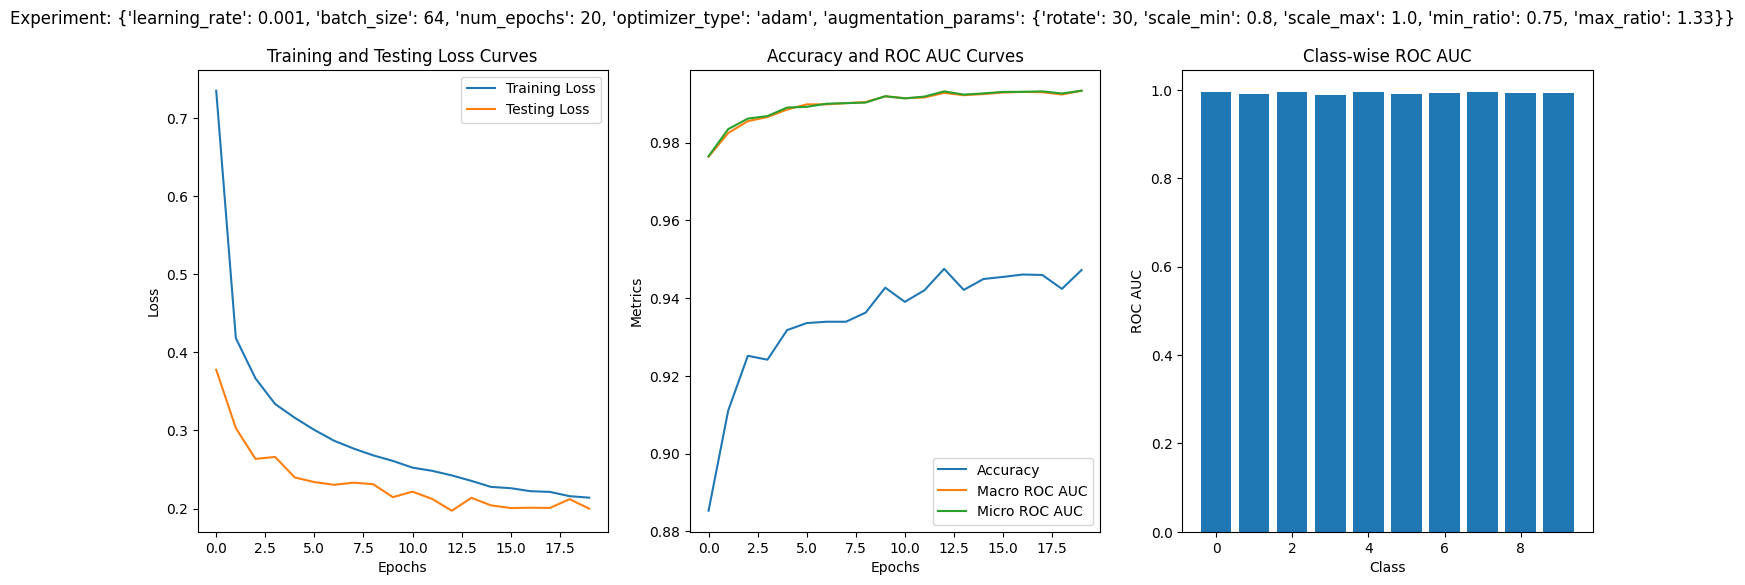

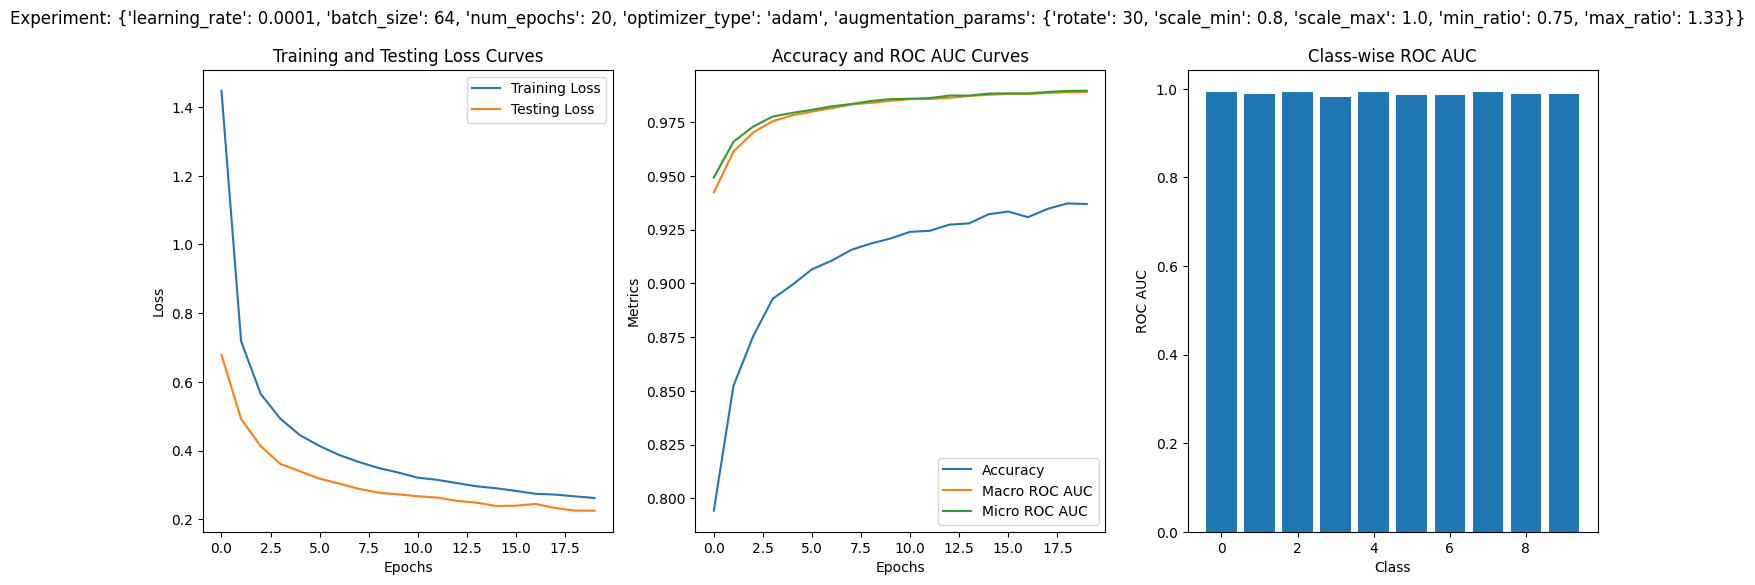

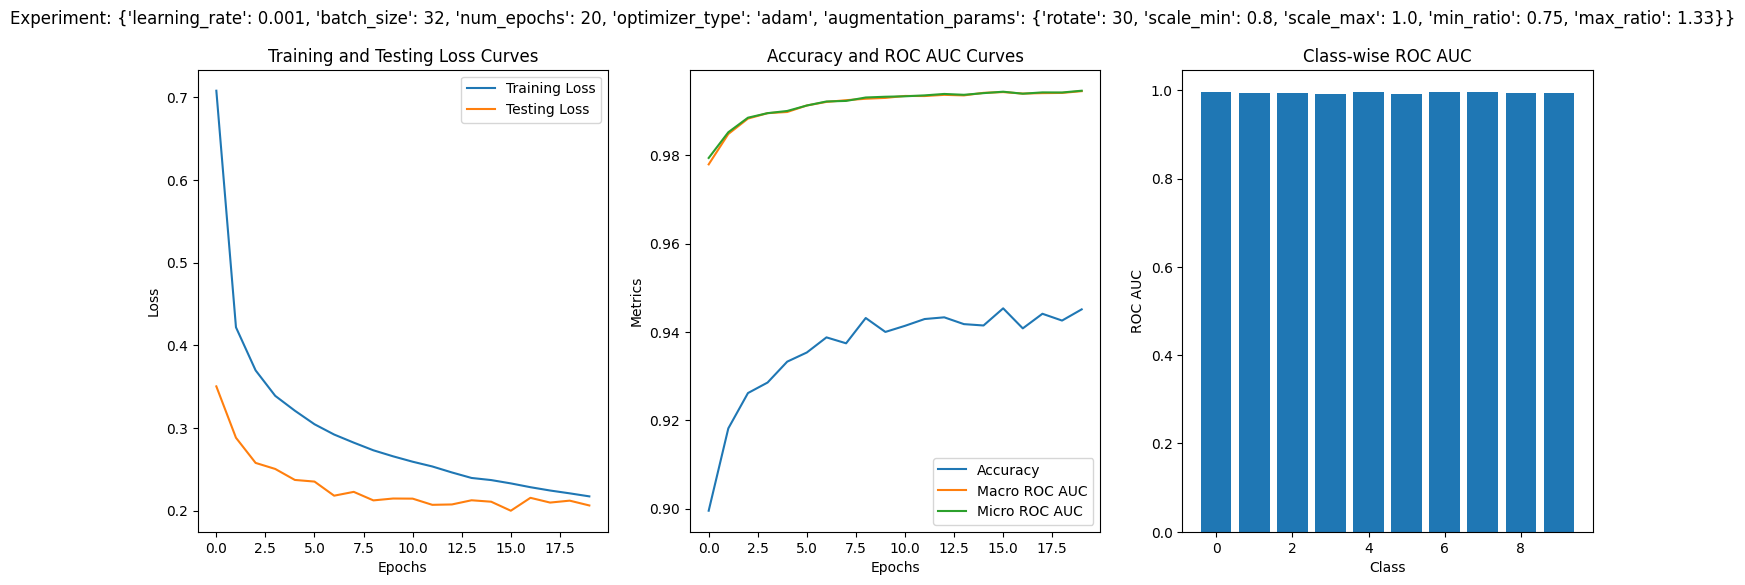

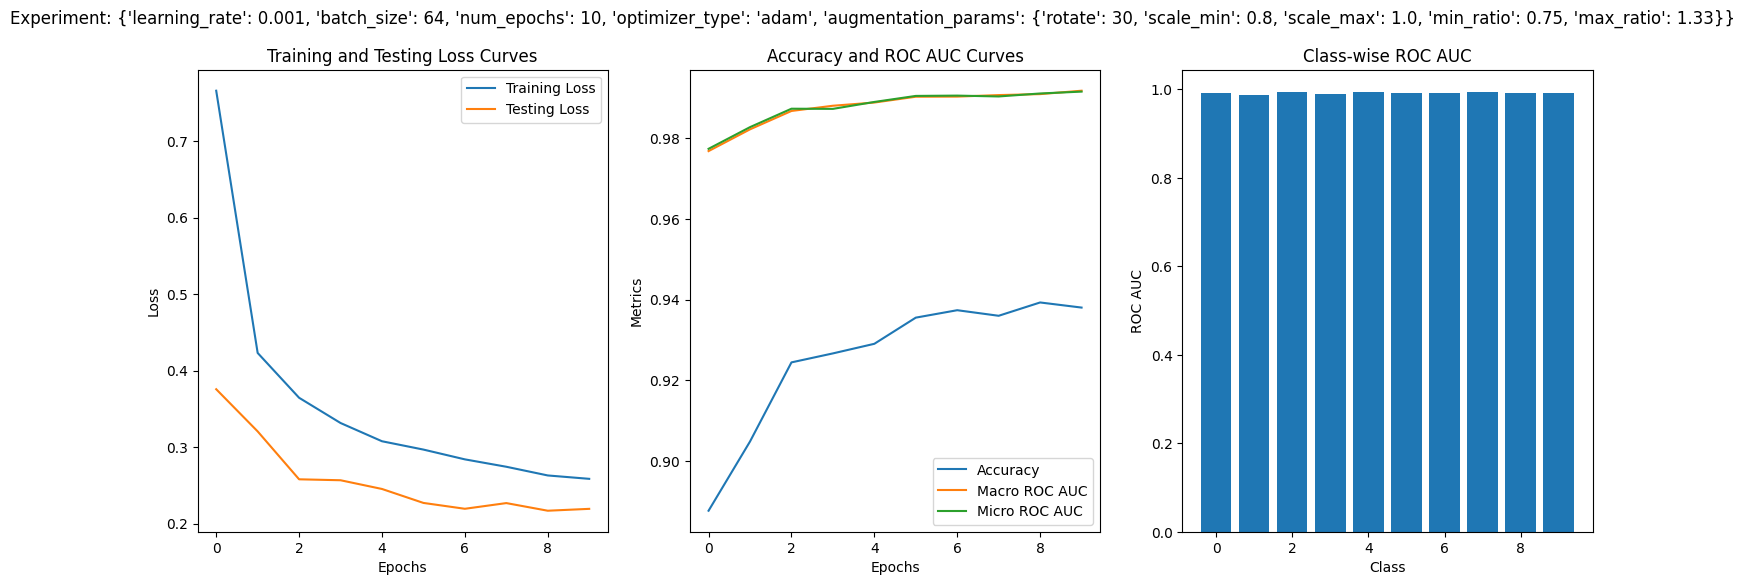

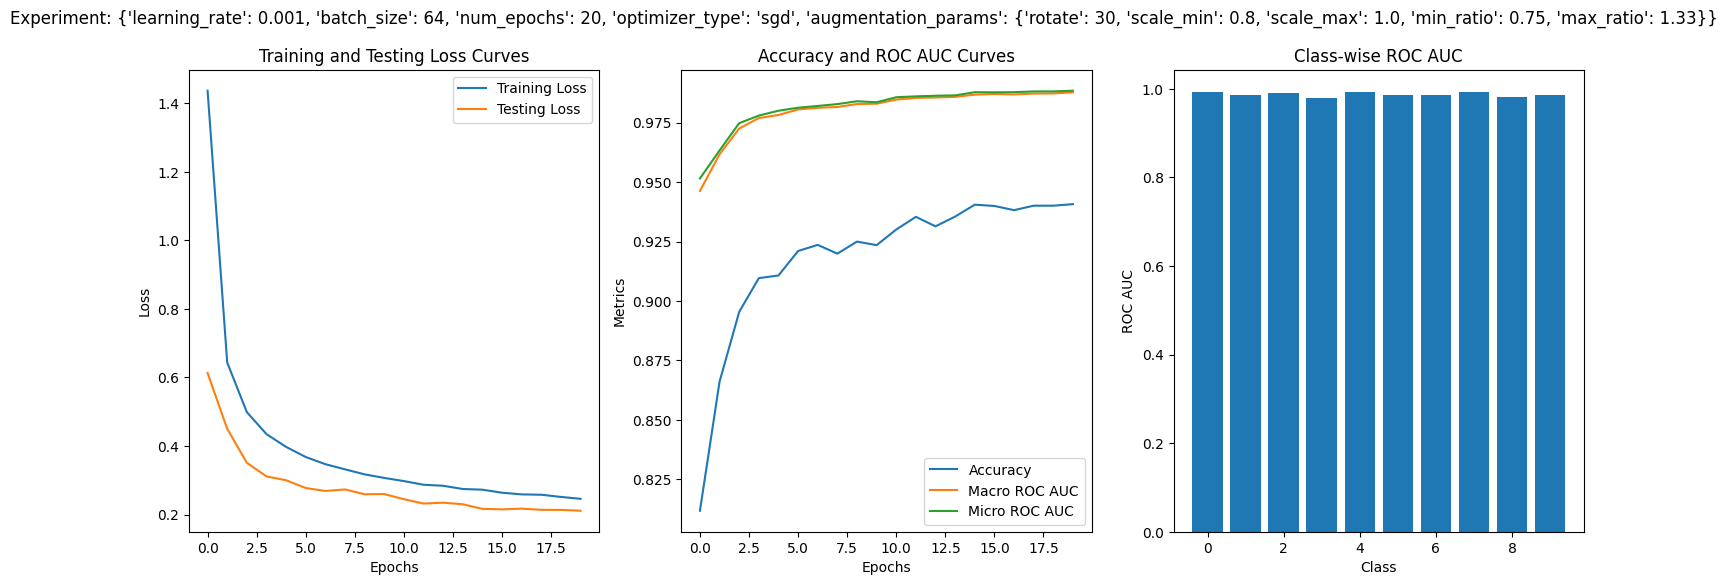

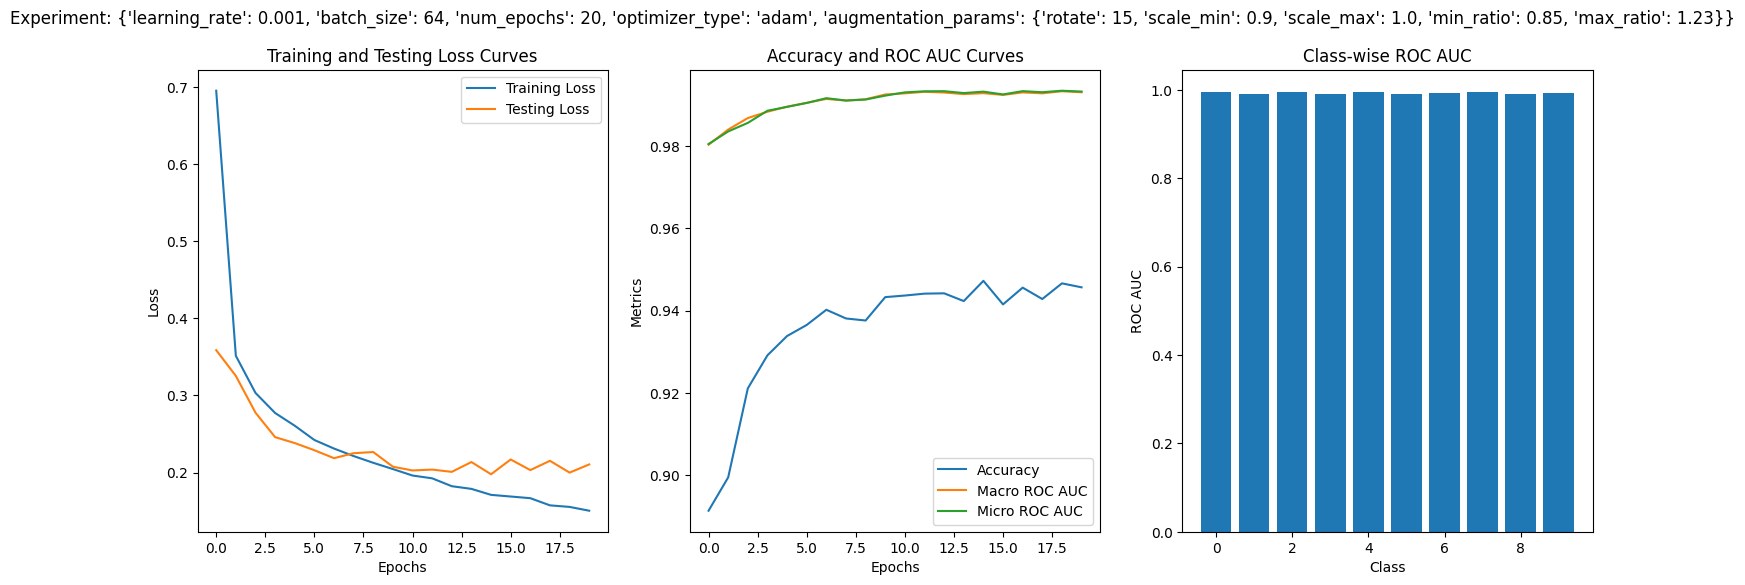

   Learning Rate  Batch Size  Num Epochs Optimizer  Rotate  Scale Min  \
0         0.0010          64          20      adam      30        0.8   
1         0.0001          64          20      adam      30        0.8   
2         0.0010          32          20      adam      30        0.8   
3         0.0010          64          10      adam      30        0.8   
4         0.0010          64          20       sgd      30        0.8   
5         0.0010          64          20      adam      15        0.9   

   Scale Max  Min Ratio  Max Ratio  Final Train Loss  Final Test Loss  \
0        1.0       0.75       1.33          0.214062         0.200033   
1        1.0       0.75       1.33          0.262110         0.225124   
2        1.0       0.75       1.33          0.217262         0.206273   
3        1.0       0.75       1.33          0.258487         0.219250   
4        1.0       0.75       1.33          0.246013         0.211248   
5        1.0       0.85       1.23          0.1504

In [12]:
# 超参数调整和实验
def run_experiment(learning_rate, batch_size, num_epochs, optimizer_type, augmentation_params):
    # 更新数据增强参数
    train_transform = A.Compose([
        A.Rotate(limit=augmentation_params['rotate'], p=0.5),
        A.RandomResizedCrop(height=32, width=32, scale=(augmentation_params['scale_min'], augmentation_params['scale_max']), ratio=(augmentation_params['min_ratio'], augmentation_params['max_ratio']), p=0.5),
        A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
        ToTensorV2()
    ])
    
    test_transform = A.Compose([
    A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
    ToTensorV2()
    ])

    # 加载数据集
    train_dataset = SVHNDataset(root="data/", split='train', transform=train_transform, download=True)
    test_dataset = SVHNDataset(root="data/", split='test', transform=test_transform, download=True)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 初始化模型
    model = VGG().to(device)
    criterion = nn.CrossEntropyLoss()

    # 选择优化器
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # 训练和评估
    train_losses = []
    test_losses = []
    accuracies = []
    macro_roc_aucs = []
    micro_roc_aucs = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy, macro_roc_auc, micro_roc_auc, all_labels, all_outputs = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
        macro_roc_aucs.append(macro_roc_auc)
        micro_roc_aucs.append(micro_roc_auc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, Macro ROC AUC: {macro_roc_auc:.4f}, Micro ROC AUC: {micro_roc_auc:.4f}")
        
        # 在训练完成后保存模型权重
        torch.save(model.state_dict(), 'vgg_model.pth')

    # 绘制类别性能的柱状图
    all_labels_one_hot = np.eye(10)[all_labels]
    class_roc_aucs = roc_auc_score(all_labels_one_hot, all_outputs, average=None, multi_class='ovr')

    return model, train_losses, test_losses, accuracies, macro_roc_aucs, micro_roc_aucs, class_roc_aucs

# 运行实验并记录结果
experiments = [
    {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}},
    # learning rate experiment
    {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}},
    # batch size experiment
    {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}},
    # num epochs experiment
    {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}},
    # optimizer experiment
    {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'sgd', 'augmentation_params': {'rotate': 30, 'scale_min': 0.8, 'scale_max': 1.0, 'min_ratio': 0.75, 'max_ratio': 1.33}},
    # augmentation experiment
    {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer_type': 'adam', 'augmentation_params': {'rotate': 15, 'scale_min': 0.9, 'scale_max': 1.0, 'min_ratio': 0.85, 'max_ratio': 1.23}},
    
]
results = []

for experiment in experiments:
    print(f"Running experiment with {experiment}")
    model, train_losses, test_losses, accuracies, macro_roc_aucs, micro_roc_aucs, class_roc_aucs = run_experiment(**experiment)
    results.append({
        'experiment': experiment,
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracies': accuracies,
        'macro_roc_aucs': macro_roc_aucs,
        'micro_roc_aucs': micro_roc_aucs,
        'class_roc_aucs': class_roc_aucs
    })

# 可视化结果
for result in results:
    experiment = result['experiment']
    train_losses = result['train_losses']
    test_losses = result['test_losses']
    accuracies = result['accuracies']
    macro_roc_aucs = result['macro_roc_aucs']
    micro_roc_aucs = result['micro_roc_aucs']
    class_roc_aucs = result['class_roc_aucs']

    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Experiment: {experiment}")

    # 绘制训练和测试损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss Curves")
    plt.legend()

    # 绘制准确率和ROC AUC曲线
    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label="Accuracy")
    plt.plot(macro_roc_aucs, label="Macro ROC AUC")
    plt.plot(micro_roc_aucs, label="Micro ROC AUC")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Accuracy and ROC AUC Curves")
    plt.legend()

    # 绘制类别性能的柱状图
    plt.subplot(1, 3, 3)
    plt.bar(range(10), class_roc_aucs)
    plt.xlabel("Class")
    plt.ylabel("ROC AUC")
    plt.title("Class-wise ROC AUC")

    plt.show()

# 使用表格总结不同实验的定量结果
summary_data = []
for result in results:
    experiment = result['experiment']
    summary_data.append({
        'Learning Rate': experiment['learning_rate'],
        'Batch Size': experiment['batch_size'],
        'Num Epochs': experiment['num_epochs'],
        'Optimizer': experiment['optimizer_type'],
        'Rotate': experiment['augmentation_params']['rotate'],
        'Scale Min': experiment['augmentation_params']['scale_min'],
        'Scale Max': experiment['augmentation_params']['scale_max'],
        'Min Ratio': experiment['augmentation_params']['min_ratio'],
        'Max Ratio': experiment['augmentation_params']['max_ratio'],
        'Final Train Loss': result['train_losses'][-1],
        'Final Test Loss': result['test_losses'][-1],
        'Final Accuracy': result['accuracies'][-1],
        'Final Macro ROC AUC': result['macro_roc_aucs'][-1],
        'Final Micro ROC AUC': result['micro_roc_aucs'][-1]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# 保存表格到文件
summary_df.to_csv('experiment_summary.csv', index=False)

# 5. Interactive Number Recognition with Gradio

In [15]:
import gradio as gr
from PIL import Image
import torchvision

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG().to(device)

# 加载权重时忽略不匹配的键
state_dict = torch.load('vgg_model.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()

# 定义预处理函数
def preprocess_image(image):
    try:
        # 打印接收到的 image 数据的详细信息
        print(f"Received image data type: {type(image)}")
        if isinstance(image, dict):
            print(f"Received image keys: {image.keys()}")
            image = image.get('composite')  # 从 'composite' 键中提取图像
            print(f"Extracted image data type: {type(image)}")
            print(f"Extracted image shape: {image.shape if isinstance(image, np.ndarray) else 'Not a numpy array'}")

        if not isinstance(image, np.ndarray):
            print("Image is not a numpy array after extraction.")
            return None

        # 将 numpy 数组转换为 RGBA 格式的 PIL 图像
        image = Image.fromarray(np.uint8(image)).convert("RGBA")

        # 创建白色背景的图像
        white_background = Image.new("RGB", image.size, (255, 255, 255))

        # 将原图粘贴到白色背景上，透明部分将变成白色
        white_background.paste(image, mask=image.split()[3])  # 使用 alpha 通道作为掩码

        # 转换为 numpy 数组以继续处理
        image = np.array(white_background)

        # 保存原始输入图像（带白色背景）
        Image.fromarray(np.uint8(image)).save('original_input_image_with_white_background.png')

        # 调整大小并转换为 Tensor
        resized_image = Image.fromarray(image).resize((32, 32))  # 只进行 resize 操作
        resized_image = np.array(resized_image)
        transformed = torch.tensor(resized_image).permute(2, 0, 1).unsqueeze(0).float().to(device)  # 转换为 Tensor 格式

        # 保存预处理后的图像以进行调试
        torchvision.utils.save_image(transformed / 255.0, 'preprocessed_image_without_norm.png')  # 将像素值归一化到 [0,1] 之间保存

        return transformed
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# 定义预测函数
def classify_digit(sketchpad_image):
    # 选择非空的图像进行处理
    image = sketchpad_image
    if image is None:
        return "No image provided."

    img_tensor = preprocess_image(image)  # 预处理图像
    if img_tensor is None:
        return "Error during preprocessing."

    try:
        with torch.no_grad():
            output = model(img_tensor)  # 运行模型
            probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]
        return {str(i): float(probabilities[i]) for i in range(10)}
    except Exception as e:
        print(f"Error during classification: {e}")
        return "Error during classification."

# 创建 Gradio 界面
sketchpad = gr.Sketchpad()  # 手绘板

# 创建 Gradio 界面
interface = gr.Interface(
    fn=classify_digit,
    inputs=sketchpad,
    outputs="label",
    live=True
)

# 启动应用
interface.launch(share=True)

C:\Users\Gu\AppData\Local\Temp\ipykernel_40084\1009893562.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('vgg_model.pth', map_location=device)


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://414b3f40336714cf83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Received image data type: <class 'dict'>
Received image keys: dict_keys(['background', 'layers', 'composite'])
Extracted image data type: <class 'numpy.ndarray'>
Extracted image shape: (600, 800, 4)
Received image data type: <class 'dict'>
Received image keys: dict_keys(['background', 'layers', 'composite'])
Extracted image data type: <class 'numpy.ndarray'>
Extracted image shape: (600, 800, 4)
Received image data type: <class 'dict'>
Received image keys: dict_keys(['background', 'layers', 'composite'])
Extracted image data type: <class 'numpy.ndarray'>
Extracted image shape: (600, 800, 4)
Received image data type: <class 'dict'>
Received image keys: dict_keys(['background', 'layers', 'composite'])
Extracted image data type: <class 'numpy.ndarray'>
Extracted image shape: (600, 800, 4)
Received image data type: <class 'dict'>
Received image keys: dict_keys(['background', 'layers', 'composite'])
Extracted image data type: <class 'numpy.ndarray'>
Extracted image shape: (600, 800, 4)
Recei